## RNN with tensorflow

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

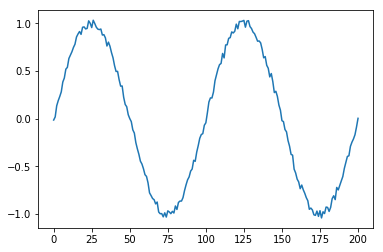

In [2]:
def sin(x, T=100):
    return np.sin(2.0*np.pi*x/T)        # 2*pi까지 한 단위로 볼때 100으로 나눔

def toy_problem(T=100, ampl=0.05):   # noise=0.05
    x = np.arange(0, 2*100+1)        # 0~200 까지 생성 , x 범위 : 0 ~ 4pi
    noise = ampl*np.random.uniform(low=-1, high=1, size=len(x))     #x의 개수 200개 만큼 -1~1 노이즈 만들기(random noise 추가)
    return sin(x) + noise

f = toy_problem(T=100, ampl=0.05)
x = np.arange(0, 2*100+1)
plt.plot(x,f)

In [3]:
length_of_sequence = 2*100
maxlen = 25 # 자료길이 25

data = []  # x 값들
target = []  # y 값
for i in range(0,length_of_sequence-maxlen + 1):
    data.append(f[i: (i+maxlen)])
    target.append(f[i+maxlen])

In [5]:
# 주의 : 차원은 맞는데 순서가 잘 들어갔는지 확인해야함
X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data),1)

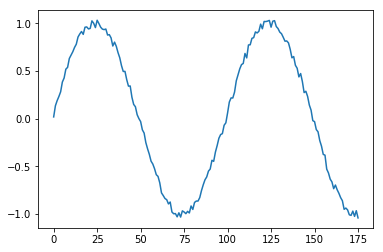

In [8]:
plt.plot(X[:, 1, 0])        # 1번째 행 가져옴.

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
N_train = int(len(data)*0.9)
N_validation = len(data)-N_train
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=N_validation)

##            
## Tensorflow

#### a(t) = g( Wxa * x(t) + Waa*a(t-1) + b)
#### y = g2(a(t)*V + c)


In [14]:
n_hidden = 30
n_batch = 176

def inference2(x, n_batch, maxlen = None, n_hidden = None, n_out = None): 
    #input은 25차원 a는 30차원 y는 1차원 데이터수는 176개
    def weight_variable(shape):
        return tf.Variable(tf.truncated_normal(shape, stddev=0.01)) # 초기화해주기
    def bias_variable(shape):
        return tf.Variable(tf.zeros(shape))
    
    #cell = tf.contrib.rnn.BasicRNNCell(n_hidden)   # RNN에서 basic cell  -> tf 로 바꾸자
    #initial_state = cell.zero_state(n_batch, tf.float32) # initial state 176x30 
    #state = initial_state # 코드에서는... state로 쓰므로... state means hidden
    
    init_state = tf.truncated_normal(shape=(n_batch, n_hidden), stddev=0.01)

    #init_state = tf.zeros(shape=(n_batch, n_hidden))   

    state=init_state
    
    
    outputs = []
    
    n_in=1; n_out=1
    Wxh = tf.get_variable('Wxh', shape=(n_in, n_hidden),   # (1,30) 꼴
                      initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
    Whh = tf.get_variable('Whh', shape=(n_hidden, n_hidden),  # (30,30) 꼴
                      initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)

    bh = tf.get_variable('bh', shape=(1, n_hidden),
                      initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)

    for t in range(maxlen):
        #concat_x = tf.concat([input_t, state[t-1]], axis=1)
        #state = tf.tanh(tf.matmul(concat_x, Wh) + bh) # [x, h(t-1)][Wxh, Whh] + bh
        
        ## relu 대신 tanh 로 쓰면 예측률이 낮아짐.
        state = tf.nn.relu(tf.matmul(x[:, t, :],Wxh) + tf.matmul(state,Whh) + bh)  
        #x(176,1)*Wxh(1,30) + h(176,30)*(30,30) + b => h(176,30)
        outputs.append(state)
         
    output = outputs[-1] # output은 제일 마지막 것 사용
    
    
    V = weight_variable([n_hidden, n_out])  # 30x1 
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c       # y = output(176x30) V(30x1) + c 를 최종 y로 쓴다  이때 V는 W_ay
    return y

In [15]:
X[:,1,:].shape

(176, 1)

In [16]:
n_in = len(X[0][0]) # num of input은 1이다.. 주가의 개수 1개~
n_hidden = 30
n_out = len(Y[0])  # num of output은 1이다

x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, shape=[]) #배치 사이즈 뭔지 몰라

y=inference2(x, n_batch, maxlen = maxlen, n_hidden = n_hidden, n_out = 1)

#주의: 두번하면 안된다.

In [17]:
def loss(y,t):
    mse = tf.reduce_mean(tf.square(y-t))
    return mse

def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
    train_step = optimizer.minimize(loss)
    return train_step

loss = loss(y,t)
train_step = training(loss)

In [18]:
epochs = 500
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

n_batches = N_train // batch_size  # 158개/10 의 몫인 15번의 배치를 돌린다.
from sklearn.utils import shuffle

In [19]:
my_loss = []
for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train)
    
    for i in range(n_batches):  #10개씩 돌리기!
        start = i* batch_size
        end = start + batch_size
    
    sess.run(train_step, feed_dict={
        x: X_[start:end], 
        t: Y_[start:end],
        n_batch: batch_size
    })                        
    # train set으로 train 하고...
    
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation, 
        t: Y_validation, 
        n_batch: N_validation
    })
    # validation set으로 loss 구하기
    
    my_loss.append(val_loss)
    print("epoch:", epoch, "validation loss:", val_loss) # 한번의 배치를  돌고나서 , validation의 loss 구하기 

epoch: 0 validation loss: 0.40501407
epoch: 1 validation loss: 0.40297434
epoch: 2 validation loss: 0.40074813
epoch: 3 validation loss: 0.39843374
epoch: 4 validation loss: 0.3959216
epoch: 5 validation loss: 0.39331585
epoch: 6 validation loss: 0.39055935
epoch: 7 validation loss: 0.3877066
epoch: 8 validation loss: 0.3847413
epoch: 9 validation loss: 0.381623
epoch: 10 validation loss: 0.3782573
epoch: 11 validation loss: 0.37433082
epoch: 12 validation loss: 0.36957765
epoch: 13 validation loss: 0.36407438
epoch: 14 validation loss: 0.35868233
epoch: 15 validation loss: 0.3530829
epoch: 16 validation loss: 0.34740537
epoch: 17 validation loss: 0.34082216
epoch: 18 validation loss: 0.33304793
epoch: 19 validation loss: 0.3246907
epoch: 20 validation loss: 0.31661654
epoch: 21 validation loss: 0.30843666
epoch: 22 validation loss: 0.30038118
epoch: 23 validation loss: 0.29253942
epoch: 24 validation loss: 0.2849962
epoch: 25 validation loss: 0.2788912
epoch: 26 validation loss: 0.273

epoch: 220 validation loss: 0.0009455798
epoch: 221 validation loss: 0.00090795517
epoch: 222 validation loss: 0.0009770901
epoch: 223 validation loss: 0.0009914698
epoch: 224 validation loss: 0.0011981574
epoch: 225 validation loss: 0.0011066622
epoch: 226 validation loss: 0.0012205301
epoch: 227 validation loss: 0.0015396829
epoch: 228 validation loss: 0.0014418836
epoch: 229 validation loss: 0.001512445
epoch: 230 validation loss: 0.0015932329
epoch: 231 validation loss: 0.0014474019
epoch: 232 validation loss: 0.0010428021
epoch: 233 validation loss: 0.0008143076
epoch: 234 validation loss: 0.00078715326
epoch: 235 validation loss: 0.0007014902
epoch: 236 validation loss: 0.00081828074
epoch: 237 validation loss: 0.0010740948
epoch: 238 validation loss: 0.0011677432
epoch: 239 validation loss: 0.0016886676
epoch: 240 validation loss: 0.0014707732
epoch: 241 validation loss: 0.0013977188
epoch: 242 validation loss: 0.001171359
epoch: 243 validation loss: 0.0009178933
epoch: 244 vali

epoch: 434 validation loss: 0.0009949082
epoch: 435 validation loss: 0.00089667115
epoch: 436 validation loss: 0.00094369455
epoch: 437 validation loss: 0.0009488752
epoch: 438 validation loss: 0.0009605418
epoch: 439 validation loss: 0.00091330655
epoch: 440 validation loss: 0.0012495914
epoch: 441 validation loss: 0.0010849056
epoch: 442 validation loss: 0.00096170325
epoch: 443 validation loss: 0.0010999957
epoch: 444 validation loss: 0.0010395148
epoch: 445 validation loss: 0.0011718782
epoch: 446 validation loss: 0.0014367236
epoch: 447 validation loss: 0.0013280367
epoch: 448 validation loss: 0.0012966059
epoch: 449 validation loss: 0.0012673025
epoch: 450 validation loss: 0.0017379721
epoch: 451 validation loss: 0.0015348512
epoch: 452 validation loss: 0.0014560496
epoch: 453 validation loss: 0.0011501389
epoch: 454 validation loss: 0.0012774012
epoch: 455 validation loss: 0.0015018907
epoch: 456 validation loss: 0.0013148327
epoch: 457 validation loss: 0.0014388548
epoch: 458 v

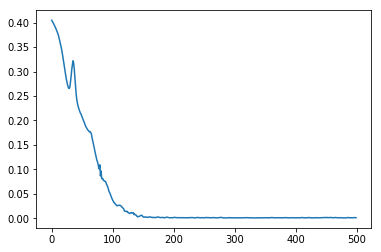

In [20]:
plt.plot(my_loss)  # validation의 loss가 점점 줄어듦을 알 수 있다.

In [21]:
truncate = maxlen  #자료길이 25
truncate
Z=X[:1]
Z.shape
original = [f[i] for i in range(maxlen)] # f[0] 에서 f[24]  25개 출력..
predicted = [None for i in range(maxlen)]

In [22]:
for i in range(length_of_sequence - maxlen +1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict={
        x: Z[-1:], 
        n_batch: 1
    })
    
    sequence_ = np.concatenate(
        (z_.reshape(maxlen, n_in)[1:], y_), axis=0).reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

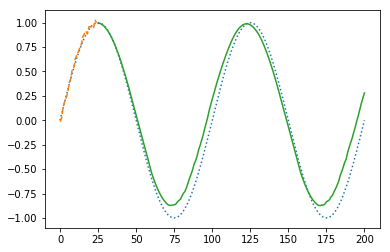

In [23]:
plt.plot(toy_problem(T=100, ampl=0), linestyle="dotted")
plt.plot(original, linestyle="dashed")
plt.plot(predicted)